# Задание 
Попробуйте обучить методом Transfer Learning одну из готовых архитектур 
* ResNet, 
* VGG,
* etc. 

используя датасет кошки против собак - 

https://www.microsoft.com/en-us/download/details.aspx?id=54765
или
https://www.kaggle.com/c/dogs-vs-cats/data

## Import

In [120]:
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Подготовка данных

In [106]:
import glob
imgs_cat = glob.glob("PetImages/Cat/*.jpg")
imgs_dog = glob.glob("PetImages/Dog/*.jpg")
print(imgs_count := len(imgs_cat) + len(imgs_dog))

25000


In [107]:
cat_df = pd.DataFrame({'filename':imgs_cat, 'label':"cat"})
dog_df = pd.DataFrame({'filename':imgs_dog, 'label':"dog"})
total_df = pd.concat([cat_df, dog_df], ignore_index=True)
display(total_df)

,filename,label
0,PetImages/Cat/3661.jpg,cat
1,PetImages/Cat/7736.jpg,cat
2,PetImages/Cat/12352.jpg,cat
3,PetImages/Cat/9805.jpg,cat
4,PetImages/Cat/957.jpg,cat
...,...,...
24995,PetImages/Dog/4504.jpg,dog
24996,PetImages/Dog/1505.jpg,dog
24997,PetImages/Dog/5701.jpg,dog
24998,PetImages/Dog/4563.jpg,dog


### Визуализация

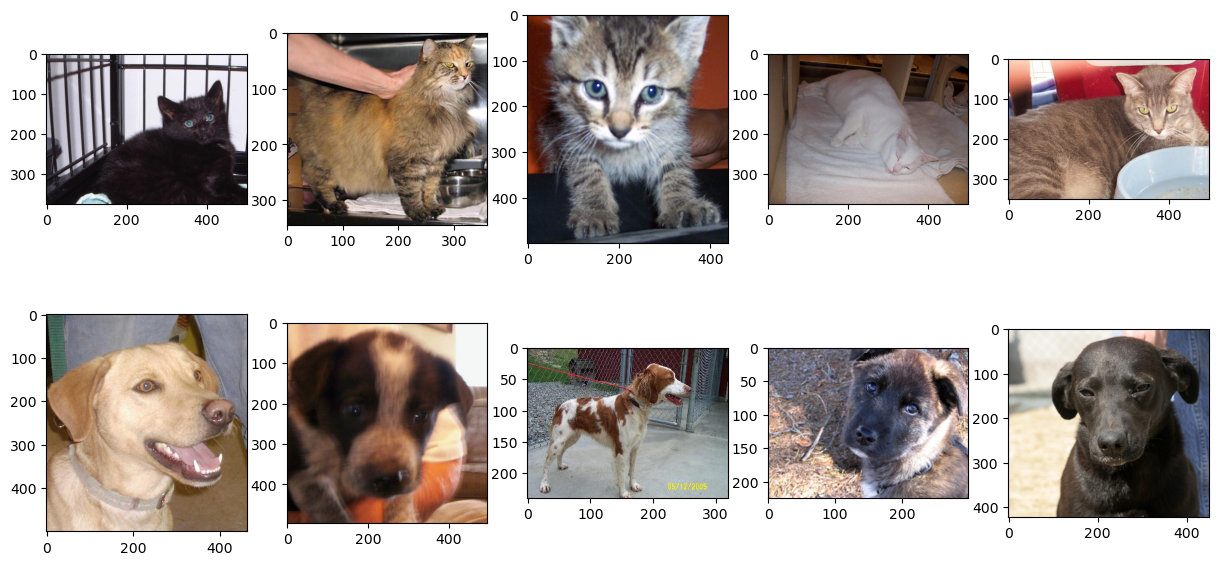

In [108]:
plt.figure(figsize=(15,7))
for i, c in enumerate(np.random.randint(0,len(cat_df),5), start=1):
    im = img.imread(cat_df.loc[c, 'filename'])
    plt.subplot(2,5,i)
    plt.imshow(im)
    
for i, c in enumerate(np.random.randint(0,len(dog_df),5), start=6):
    im = img.imread(dog_df.loc[c, 'filename'])
    plt.subplot(2,5,i)
    plt.imshow(im)

In [ ]:
input_shape =  (500, 375, 3)

### Разбиение на тренировочную и проверочную выборку

In [109]:
train_set, valid_set = train_test_split(total_df, test_size=0.2)
print(f"Train set shape {train_set.shape}")
print(f"Validation set shape {train_set.shape}")

Train set shape (20000, 2)
Validation set shape (20000, 2)


In [110]:
print(f"Train set distribution: \n{train_set['label'].value_counts()}")
print(f"\nValidation set distribution: \n{valid_set['label'].value_counts()}")


Train set distribution: 
cat    10033
dog     9967
Name: label, dtype: int64

Validation set distribution: 
dog    2533
cat    2467
Name: label, dtype: int64


### Дата генератор

In [121]:
train_datagenerator = ImageDataGenerator(rotation_range=15, 
                                  rescale=1./255, 
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)

training_data = train_datagenerator.flow_from_dataframe(dataframe=train_set, 
                                                        directory='./train',
                                                       x_col='filename',
                                                       y_col='label',
                                                       target_size=(WIDTH, HEIGHT),
                                                       class_mode='categorical',
                                                       batch_size=batch_size)

NameError: name 'WIDTH' is not defined

In [111]:

#image = load_img(image_source, target_size=input_shape)

## Модель

In [114]:
def createTLNN():
    model = Sequential()
    
    modelTL = tf.keras.applications.vgg19.VGG19(input_shape = input_shape, include_top = False, weights = 'imagenet')
    modelTL.trainable = False
    model.add(modelTL)

    model.add(L.Flatten()) #2048
    model.add(L.Dense(128, activation='relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(2, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [115]:
model = createTLNN()


2022-10-18 18:13:31.338299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:13:31.394042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:13:31.394098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-18 18:13:31.399521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow 

80134624/80134624 [==============================] - 7s 0us/step


/home/leysh/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
